In [1]:
import shap
import joblib
import numpy as np
import pandas as pd
import pickle
#import pyarrow as pa
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import logging
#import matplotlib

/home/julian/.conda/envs/shap0040/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CpredictorClassifier():
    def __init__(self, Threshold_rej, rejected, OutputDir):
        self.scaler = MinMaxScaler()
        self.Classifier = LinearSVC(dual = False, random_state = 42, class_weight = 'balanced', max_iter = 2500)
        self.threshold = Threshold_rej
        self.rejected = rejected
        self.output_dir = OutputDir
        self.expression_treshold = 162

    def expression_cutoff(self, Data, LabelsPath):
        logging.info(f'Selecting genes based on an summed expression threshold of minimally {self.expression_treshold} in each cluster')
        labels = pd.read_csv(LabelsPath,index_col=False)
        h5ad_object = Data.copy()
        cluster_id = 'labels'
        h5ad_object.obs[cluster_id] = labels.iloc[:, 0].tolist()
        res = pd.DataFrame(columns=h5ad_object.var_names.tolist(), index=h5ad_object.obs[cluster_id].astype("category").unique())
        
        ## Set up scanpy object based on expression treshold
        for clust in h5ad_object.obs[cluster_id].astype("category").unique():
            if h5ad_object.raw is not None:
                res.loc[clust] = h5ad_object[h5ad_object.obs[cluster_id].isin([clust]),:].raw.X.sum(0)
            else:
                res.loc[clust] = h5ad_object[h5ad_object.obs[cluster_id].isin([clust]),:].X.sum(0)
        res.loc["sum"]=np.sum(res,axis=0).tolist()
        res=res.transpose()
        res=res.loc[res['sum'] > self.expression_treshold]
        genes_expressed = res.index.tolist()
        logging.info("Amount of genes that remain: " + str(len(genes_expressed)))
        h5ad_object = h5ad_object[:, genes_expressed]
        Data = h5ad_object
        del res, h5ad_object

        return Data
        
    def preprocess_data_train(self, data_train):
        logging.info('Log normalizing the training data')
        np.log1p(data_train, out=data_train)
        logging.info('Scaling the training data')
        data_train = self.scaler.fit_transform(data_train)
        return data_train

    def preprocess_data_test(self, data_test):
        logging.info('Log normalizing the testing data')
        np.log1p(data_test, out=data_test)
        logging.info('Scaling the testing data')
        data_test = self.scaler.fit_transform(data_test)
        return data_test

    def fit_and_predict_svmrejection(self, labels_train, threshold, output_dir, data_train, data_test):
        self.rejected = True
        self.threshold = threshold
        self.output_dir = output_dir
        logging.info('Running SVMrejection')
        kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
        clf = CalibratedClassifierCV(self.Classifier, cv=kf)
        clf.fit(data_train, labels_train.ravel())
        predicted = clf.predict(data_test)
        prob = np.max(clf.predict_proba(data_test), axis = 1)
        unlabeled = np.where(prob < self.threshold)

        # For unlabeled values from the SVMrejection put values of strings and integers
        try:
            predicted[unlabeled] = 'Unlabeled'
        except ValueError:
            unlabeled = list(unlabeled[0])
            predicted[unlabeled] = 999999
        self.predictions = predicted
        self.probabilities = prob
        self.save_results(self.rejected)

    def fit_and_predict_svm(self, labels_train, output_dir, data_train, data_test):
        self.rejected = False
        self.output_dir = output_dir
        logging.info('Running SVM')
        self.Classifier.fit(data_train, labels_train.ravel())
        self.predictions = self.Classifier.predict(data_test)
        self.save_results(self.rejected)

    def save_results(self, rejected):
        self.rejected = rejected
        self.predictions = pd.DataFrame(self.predictions)
        if self.rejected is True:
            self.probabilities = pd.DataFrame(self.probabilities)
            self.predictions.to_csv(f"{self.output_dir}/SVMrej_Pred_Labels.csv", index=False)
            self.probabilities.to_csv(f"{self.output_dir}/SVMrej_Prob.csv", index=False)
        else:
            self.predictions.to_csv(f"{self.output_dir}/SVM_Pred_Labels.csv", index=False)

# Child class for performance from the CpredictorClassifier class        
class CpredictorClassifierPerformance(CpredictorClassifier):
    def __init__(self, Threshold_rej, rejected, OutputDir):
        super().__init__(Threshold_rej, rejected, OutputDir)

    def fit_and_predict_svmrejection(self, labels_train, threshold, output_dir, data_train, data_test):
        # Calls the function from parent class and extends it for the child
        super().fit_and_predict_svmrejection(labels_train, threshold, output_dir, data_train, data_test)
        return self.predictions, self.probabilities

    def fit_and_predict_svm(self, labels_train, OutputDir, data_train, data_test):
        # Calls the function from parent class and extends it for the child
        super().fit_and_predict_svm(labels_train, OutputDir, data_train, data_test)
        return self.predictions

In [3]:
#!pip3 install scikit-learn==1.4.2

In [4]:
# Still to do!
cls = joblib.load("models_after_training_rfe3/model_SVMrej.pkl")

In [5]:
# Get the X-train (used the test as training for illustrative purposes):
import pyarrow as pa
with pa.memory_map('models_after_training_rfe3/data_test.arrow', 'rb') as source:
    data_test = pa.ipc.open_file(source).read_all()
    data_test = data_test.to_pandas().to_numpy()
data_test

array([[  0., 197.,  61., ...,   0.,   0.,   0.],
       [  0., 226.,  24., ...,   0.,   1.,   0.],
       [  0., 110.,  32., ...,   0.,   0.,   0.],
       ...,
       [  0., 134.,   8., ...,   0.,   0.,   0.],
       [  0., 227.,  46., ...,   0.,   0.,   0.],
       [  0.,  20.,  10., ...,   0.,   0.,   0.]], dtype=float16)

In [6]:
data_test.shape

(65036, 1242)

In [7]:
with open ('models_after_training_rfe3/mergedgenes', 'rb') as fp:
    features = pickle.load(fp)
features

['GIMAP4',
 'MT-ND4',
 'RPS2',
 'TMPRSS11D',
 'CYTL1',
 'ILVBL',
 'H2AFY',
 'RGS1',
 'PABPC1',
 'RACK1',
 'NUDT4',
 'SRFBP1',
 'UQCR11',
 'HLA-DRB5',
 'EEF1G',
 'SLC3A2',
 'TMSB10',
 'TGM2',
 'CLDN5',
 'DSTN',
 'ADCY4',
 'HSPH1',
 'NAB1',
 'CYGB',
 'POMGNT1',
 'SLK',
 'OSTM1',
 'RPS18',
 'COL1A1',
 'CD81',
 'HCLS1',
 'RAN',
 'DDIT4',
 'KRT12',
 'MTRNR2L1',
 'SNHG8',
 'CCL2',
 'RPS27',
 'NANOS1',
 'MT-ND6',
 'ADGRL4',
 'CCND1',
 'DUSP23',
 'ADD3',
 'PHLDA1',
 'MLST8',
 'ID1',
 'TP53I3',
 'AMD1',
 'ALDH1A1',
 'CYB561A3',
 'PLXNC1',
 'COL12A1',
 'MFGE8',
 'PAG1',
 'MGARP',
 'IL18',
 'PGAM1',
 'IL1RN',
 'GSTA4',
 'AC011446.2',
 'S1PR1',
 'DEPP1',
 'APOE',
 'DEGS1',
 'SDCBP2',
 'KRT17',
 'SLC9A3R2',
 'WNT10A',
 'GPM6B',
 'CENPT',
 'KLK11',
 'INSIG1',
 'MYL12B',
 'CD99',
 'TWIST1',
 'PSMD12',
 'ADH7',
 'TRIB2',
 'GNAS',
 'PMEPA1',
 'MXI1',
 'PITX2',
 'RBPMS',
 'TMSB4X',
 'LAMB2',
 'PPP1R14B',
 'RCAN2',
 'NDUFA13',
 'TLE4',
 'NAP1L1',
 'SYT8',
 'MFSD4A',
 'PMAIP1',
 'H2AFJ',
 'ITM2A',
 'PRDX1

In [8]:
Threshold_rej = 0.7
rejected = True
OutputDir = "data2/"
cpredictor = CpredictorClassifier(Threshold_rej, rejected, OutputDir)

In [9]:
data_test = cpredictor.preprocess_data_test(data_test)

In [10]:
data_test.shape

(65036, 1242)

In [11]:
data_test

array([[0.    , 0.692 , 0.584 , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.71  , 0.4553, ..., 0.    , 0.2212, 0.    ],
       [0.    , 0.6167, 0.4946, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.642 , 0.3108, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.7104, 0.5444, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3984, 0.3394, ..., 0.    , 0.    , 0.    ]],
      dtype=float16)

In [12]:
data_test = pd.DataFrame(data_test, columns=features)
data_test

,GIMAP4,MT-ND4,RPS2,TMPRSS11D,CYTL1,ILVBL,H2AFY,RGS1,PABPC1,RACK1,...,F2R,TP53TG1,SLPI,CBR1,SNCA,HSPB1,ELP4,ANGPTL5,ZNF385D,CPVL
0,0.0,0.691895,0.583984,0.354492,0.0,0.39624,0.373535,0.0,0.441650,0.514648,...,0.000000,0.561523,0.382812,0.185547,0.000000,0.508301,0.000000,0.000000,0.000000,0.000000
1,0.0,0.709961,0.455322,0.177246,0.0,0.00000,0.295898,0.0,0.441650,0.465332,...,0.000000,0.354492,0.460693,0.185547,0.000000,0.558105,0.000000,0.000000,0.221191,0.000000
2,0.0,0.616699,0.494629,0.177246,0.0,0.39624,0.433350,0.0,0.132935,0.491943,...,0.000000,0.354492,0.382812,0.520996,0.000000,0.518066,0.187866,0.000000,0.000000,0.000000
3,0.0,0.588867,0.481201,0.000000,0.0,0.00000,0.186768,0.0,0.505859,0.465332,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.350830,0.000000,0.517578,0.000000,0.000000
4,0.0,0.748535,0.339355,0.000000,0.0,0.00000,0.000000,0.0,0.398926,0.378174,...,0.000000,0.497559,0.000000,0.371094,0.000000,0.469971,0.187866,0.000000,0.000000,0.543457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65031,0.0,0.287598,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.132935,0.227661,...,0.175537,0.000000,0.000000,0.000000,0.000000,0.350830,0.000000,0.000000,0.000000,0.171509
65032,0.0,0.619629,0.510742,0.000000,0.0,0.00000,0.000000,0.0,0.421387,0.455322,...,0.000000,0.000000,0.247314,0.293945,0.000000,0.189819,0.187866,0.000000,0.000000,0.000000
65033,0.0,0.642090,0.310791,0.000000,0.0,0.25000,0.000000,0.0,0.308594,0.264160,...,0.175537,0.177246,0.201660,0.000000,0.000000,0.189819,0.187866,0.000000,0.000000,0.000000
65034,0.0,0.710449,0.544434,0.000000,0.0,0.00000,0.295898,0.0,0.617188,0.578613,...,0.000000,0.280762,0.123657,0.371094,0.442383,0.094910,0.000000,0.000000,0.000000,0.000000


# Joined: Values of 6x15 specific cells background on 6x15 specific selected cells


In [ ]:
cell="Joined"
# Cell numbers for LSC-1: 43085, 54, 102, 226, 21149, 40716, for others see below
# See data_test specification in cells above
cell_nums = [43085, 54, 102, 226, 21149, 40716,245,2092,15680,21830,40692,64101,
3042, 7585, 20935, 38122, 44845, 53940,
2,14705,33609,42727,56478,64996,
266, 7968, 12649, 29718, 43413, 54792,
1076,13484,21232,28540,48553,53244,
68, 18505, 22454, 30609, 30945, 32099,
8558, 32245, 32550, 33634, 33834, 58985,
31, 15040, 34168, 36238, 58954, 61494,
27102, 27310, 28645, 29011, 29033, 33802,
149, 7255, 14334, 20927, 40040, 54911,
519, 12330, 40911, 48406, 53573, 62691,
239, 6982, 13451, 24791, 26765, 64913,
375, 1554, 5004, 20956, 61871, 64328,
2049, 7429, 12622, 20962, 42970, 62700]
trial = data_test.iloc[cell_nums]
trial["TP63"]

43085    0.210449
54       0.210449
102      0.333496
226      0.000000
21149    0.420898
           ...   
7429     0.000000
12622    0.000000
20962    0.000000
42970    0.000000
62700    0.000000
Name: TP63, Length: 90, dtype: float16

In [14]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [15]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# For three cells -> takes about 12 minutes in total -> perhaps then logical if cells are similar?
# For 10 cells -> takes about 27 minutes per fold; but very high memory already -> 53 GB not more than this
# For 6 cells -> 1:34:06 total
# Newest selection for 6 cells -> 3 minutes total
# For 6*15 cells joined -> 2:17:47

100%|██████████| 90/90 [1:05:04<00:00, 43.39s/it]


In [16]:
shap_values

[array([[ 0.00000000e+00,  1.31546109e-03,  0.00000000e+00, ...,
          1.94498250e-03,  1.02713298e-05,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.40384128e-03,  0.00000000e+00, -2.26407137e-04],
        ...,
        [ 0.00000000e+00, -5.33153488e-05,  0.00000000e+00, ...,
          3.02590127e-04,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.40677564e-03,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  6.52512220e-04],
        [ 0.00000000e+00, -1.13853086e-03, -9.97524344e-05, ...,
          0.00000000e+00,  0.00000000e+00,  7.12075679e-04]]),
 array([[ 0.        ,  0.00136972,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00144531,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.

In [17]:
# Top 50 features for each cell state
import numpy as np
list_states = ["CE", "CF", "Cj", "EC", "IC", "LE", "LESC", "LSC", "MC", "Mel", "SK", "TSK", "Ves", "nm-CSC", "qSK"]
for count, value in enumerate(list_states):
    shap_sel = [shap_values[count]]
    vals= np.abs(shap_sel).mean(0)

    feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    feature_importance.head(50)

    top_shap = feature_importance.head(50)
    top_shap

    top_shap.to_csv(f'models_after_training_rfe3/{value}_shap_50.csv', sep='\t', index=False, header=True)

In [18]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(400)

top_shap = feature_importance.head(400)
top_shap

top_shap.to_csv(f'models_after_training_rfe3/{cell}_shap_400.csv', sep='\t', index=False, header=True)

In [19]:
feature_importance.head(150)

,col_name,feature_importance_vals
325,MT1X,0.219818
318,PERP,0.197395
636,KRT5,0.181311
850,APOD,0.174709
1015,DCN,0.169795
...,...,...
147,TXNIP,0.070321
1237,HSPB1,0.070095
253,SPARC,0.069942
1223,RPL18A,0.069890


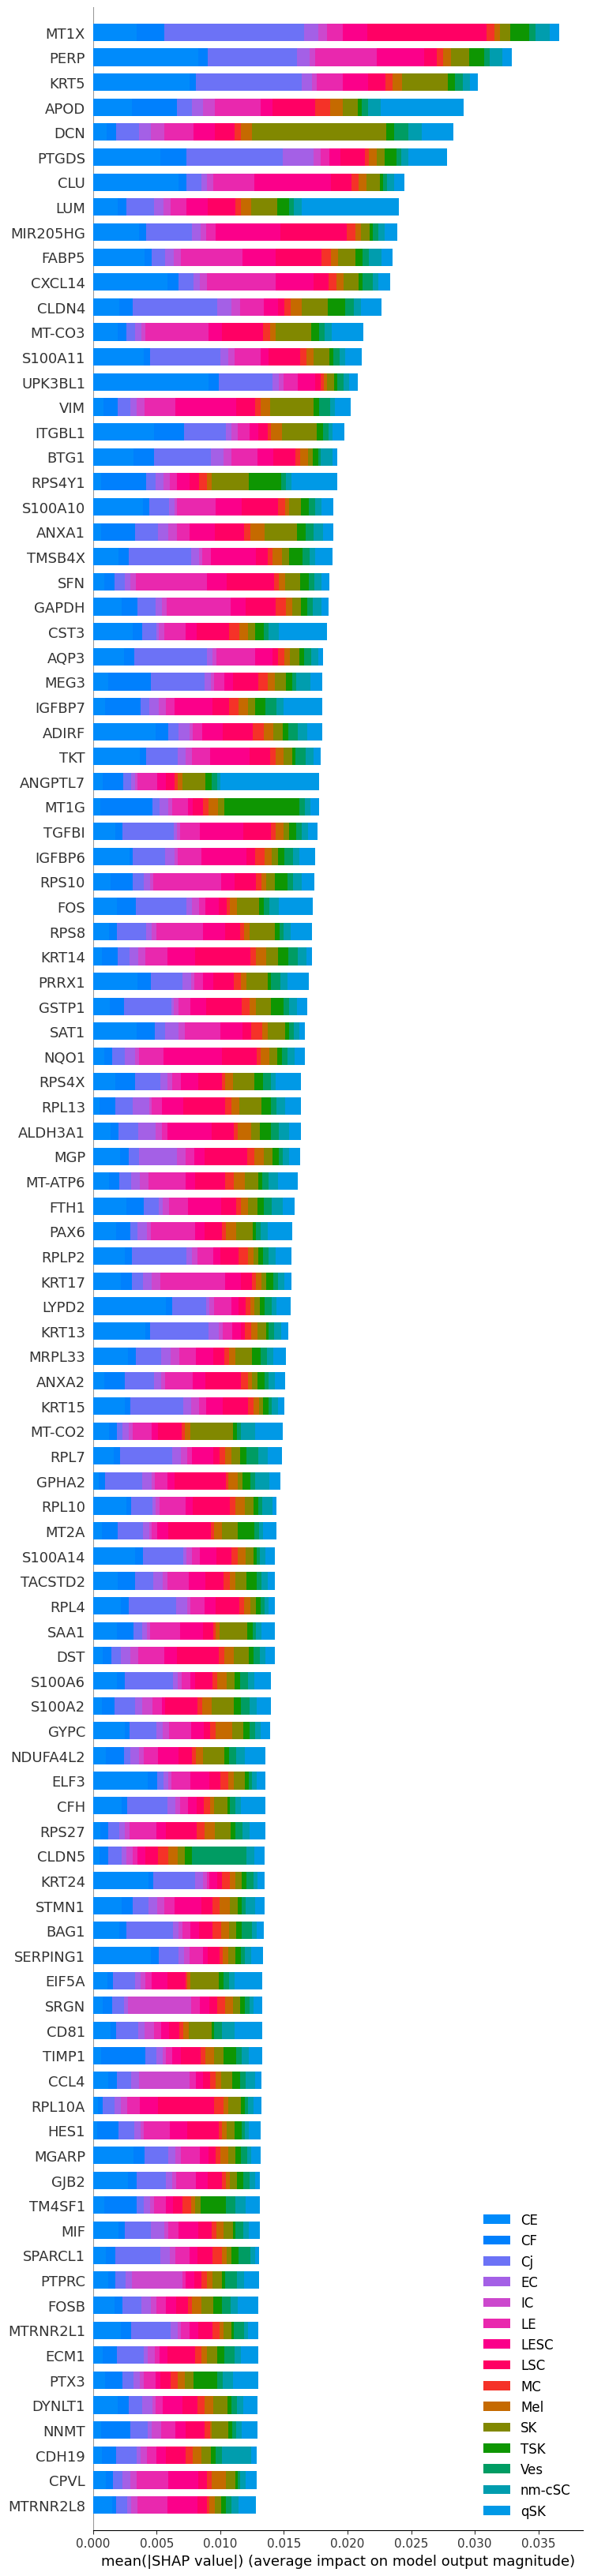

In [20]:
shap.summary_plot(shap_values, data_test.iloc[cell_nums], class_inds="original", class_names=cls.classes_,max_display=100)
#shap 0.40.0

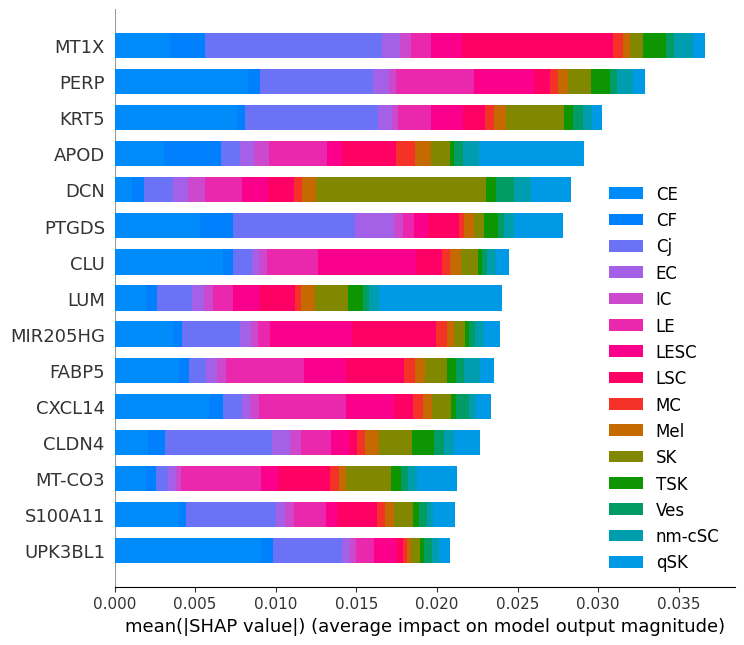

In [21]:
shap.summary_plot(shap_values, data_test.iloc[cell_nums], class_inds="original", class_names=cls.classes_,max_display=15)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


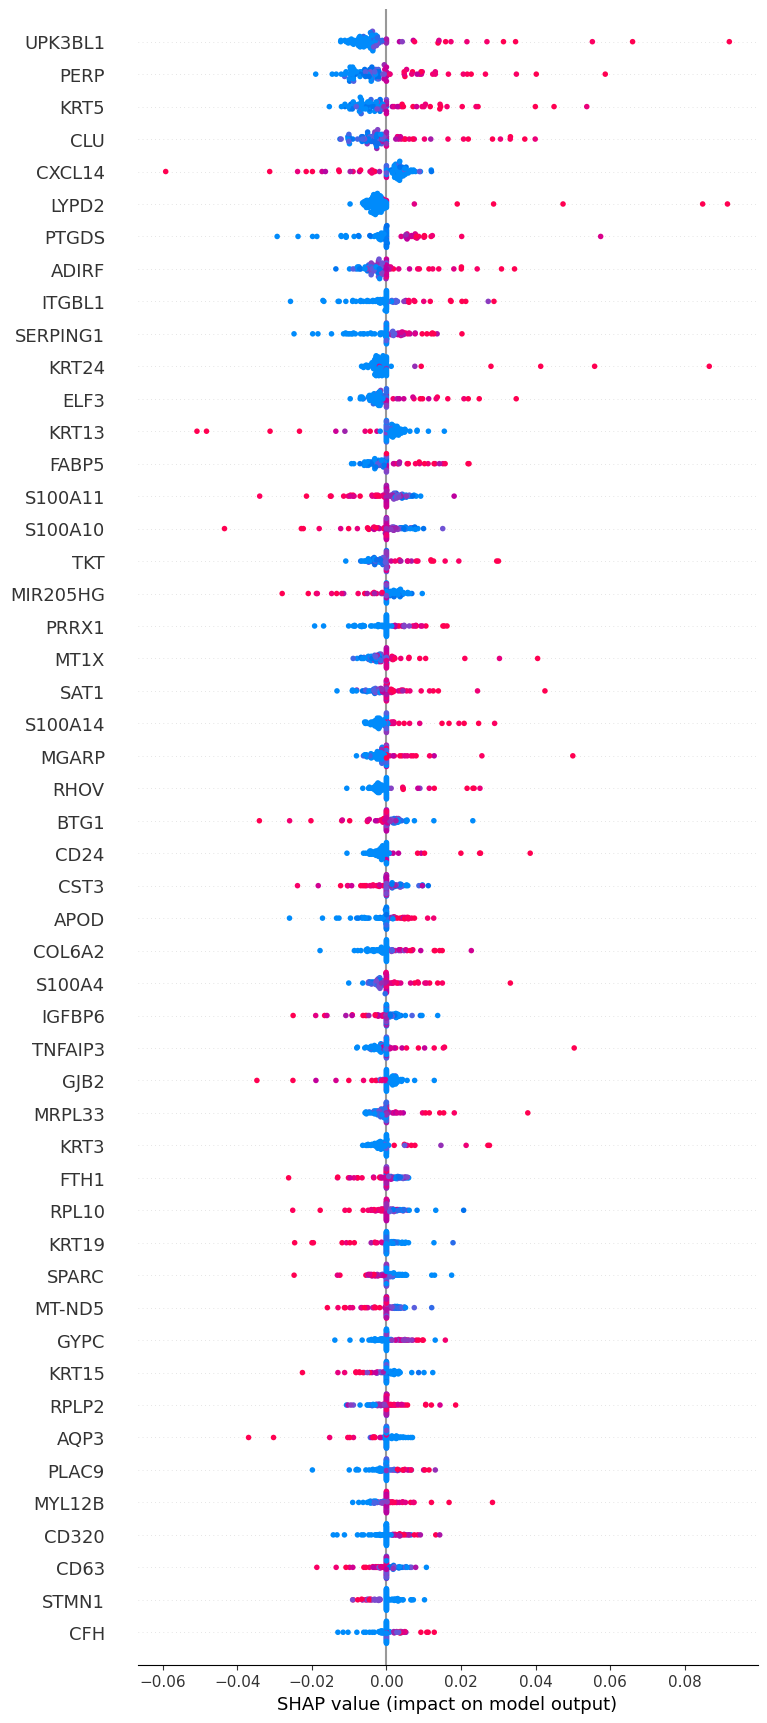

In [22]:
shap.summary_plot(shap_values[0], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


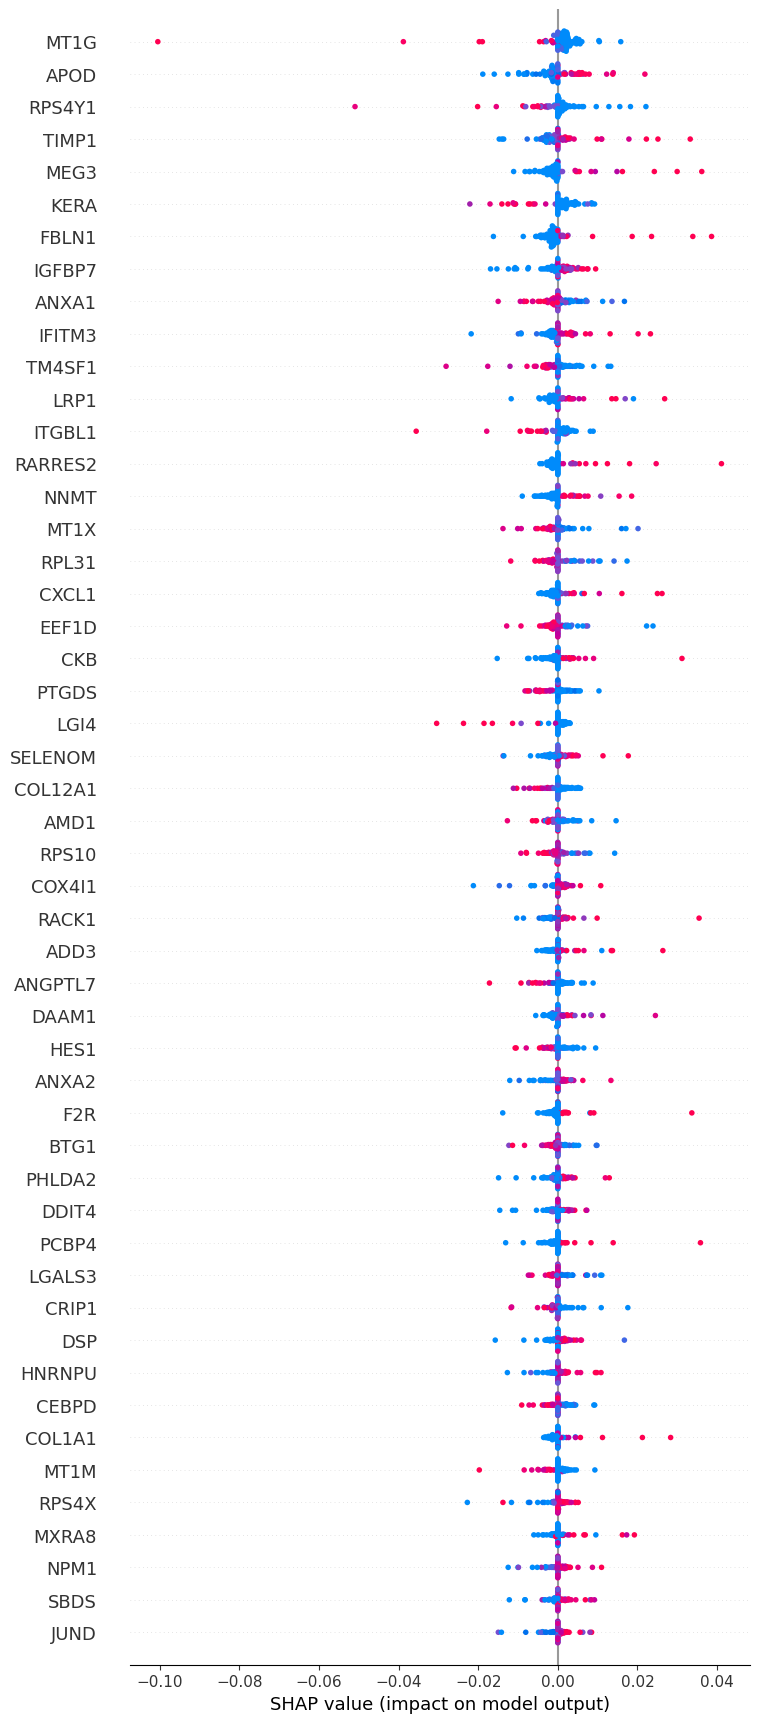

In [23]:
shap.summary_plot(shap_values[1], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


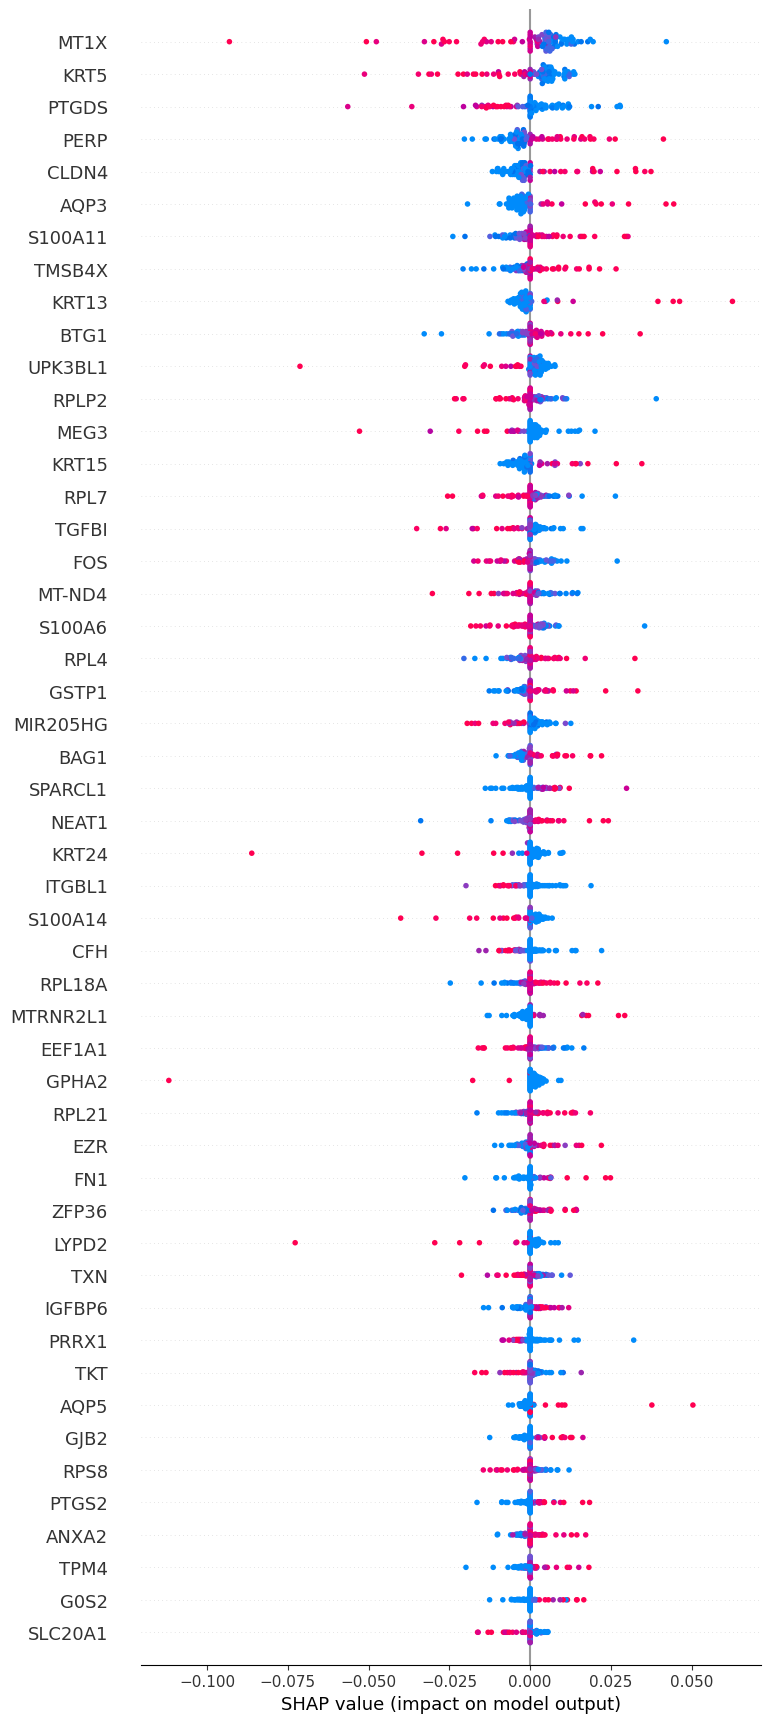

In [24]:
shap.summary_plot(shap_values[2], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


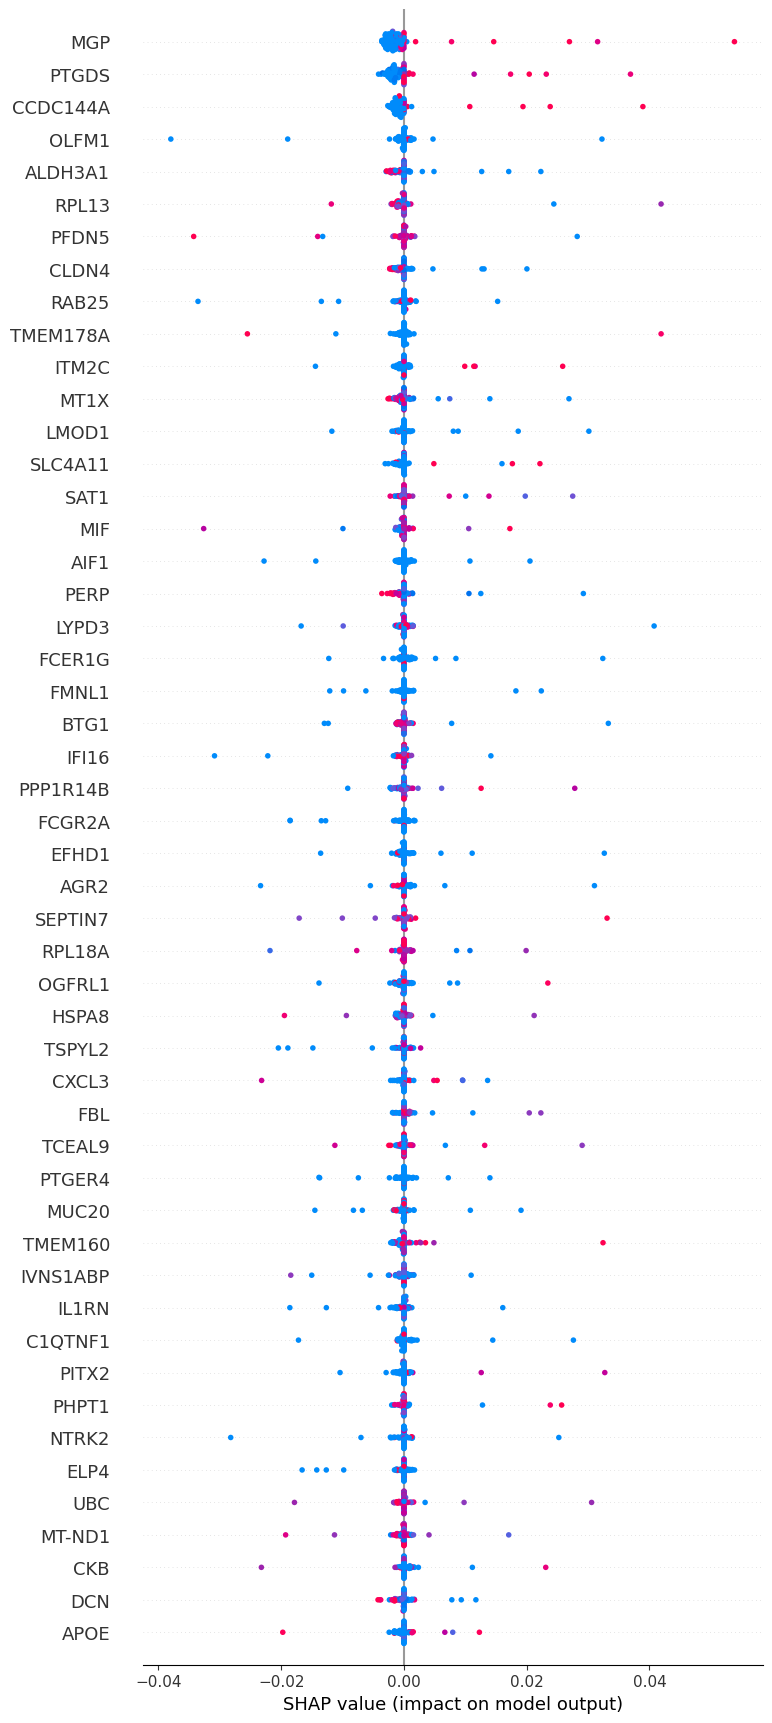

In [25]:
shap.summary_plot(shap_values[3], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


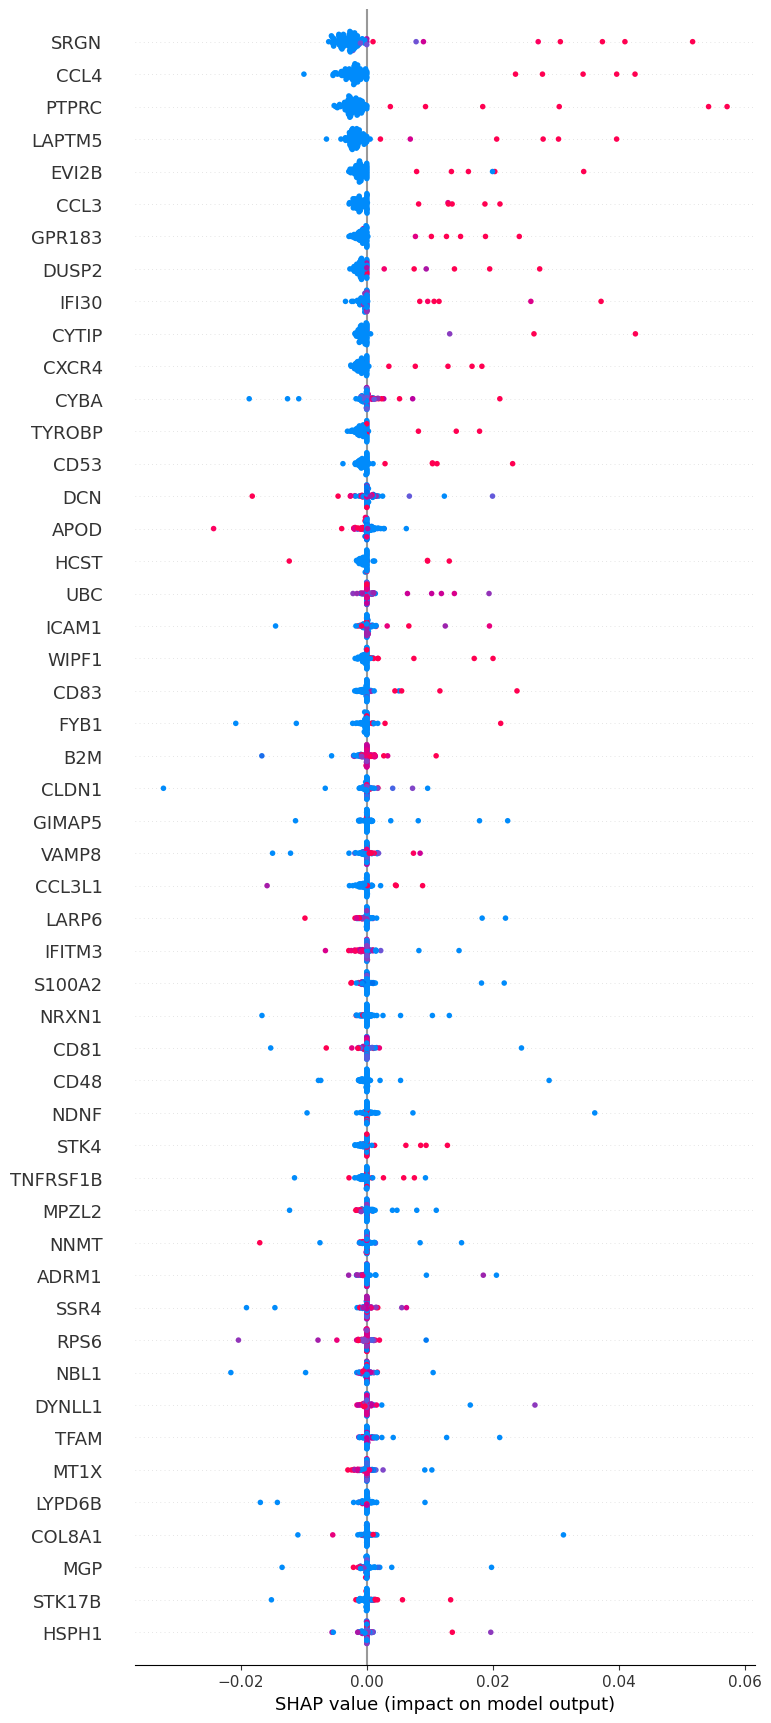

In [26]:
shap.summary_plot(shap_values[4], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


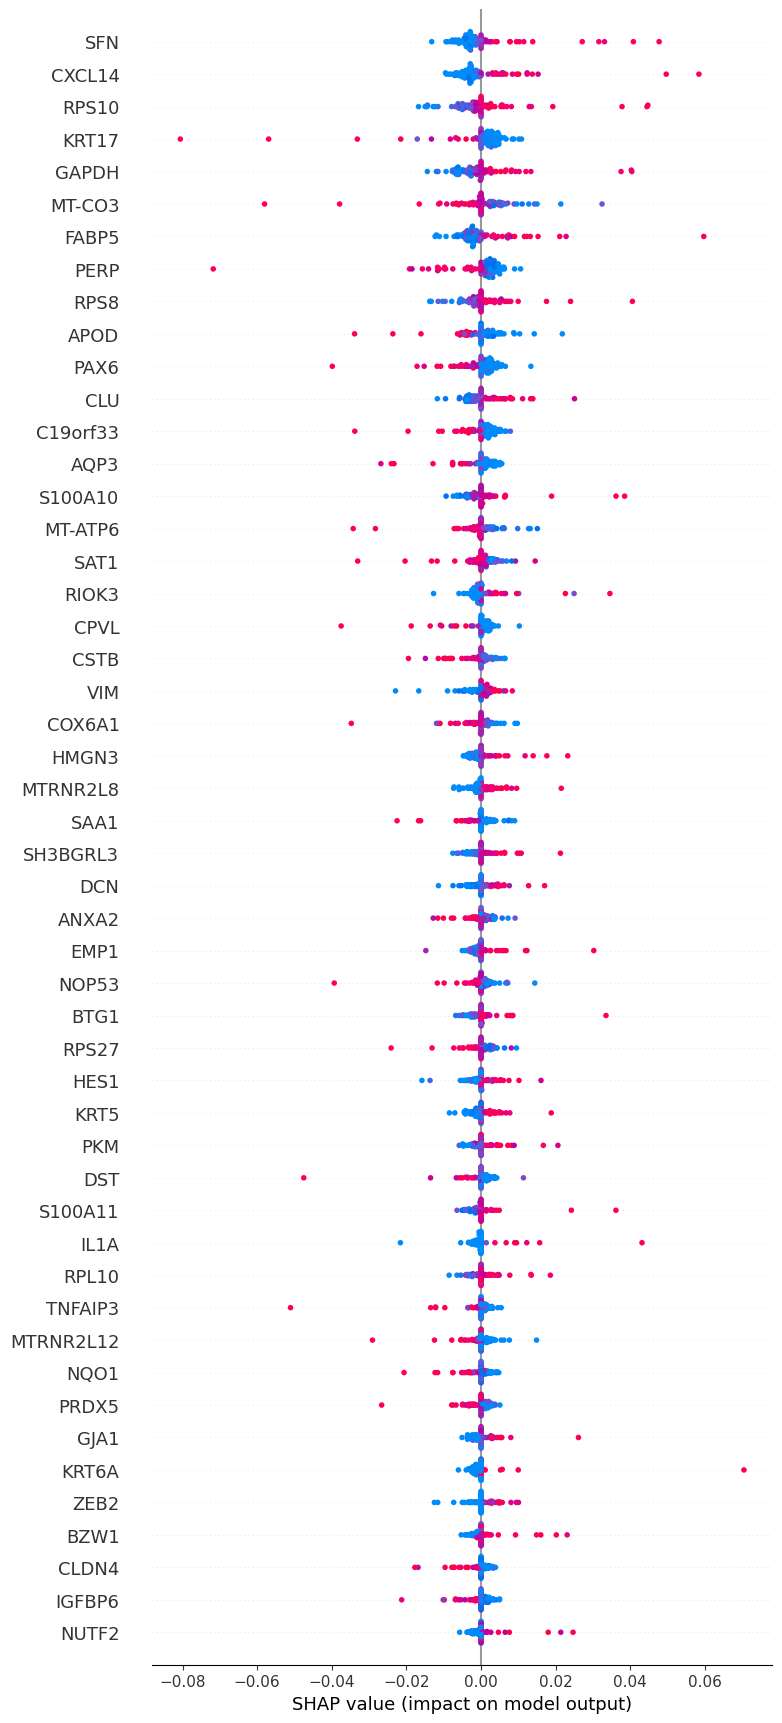

In [27]:
shap.summary_plot(shap_values[5], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


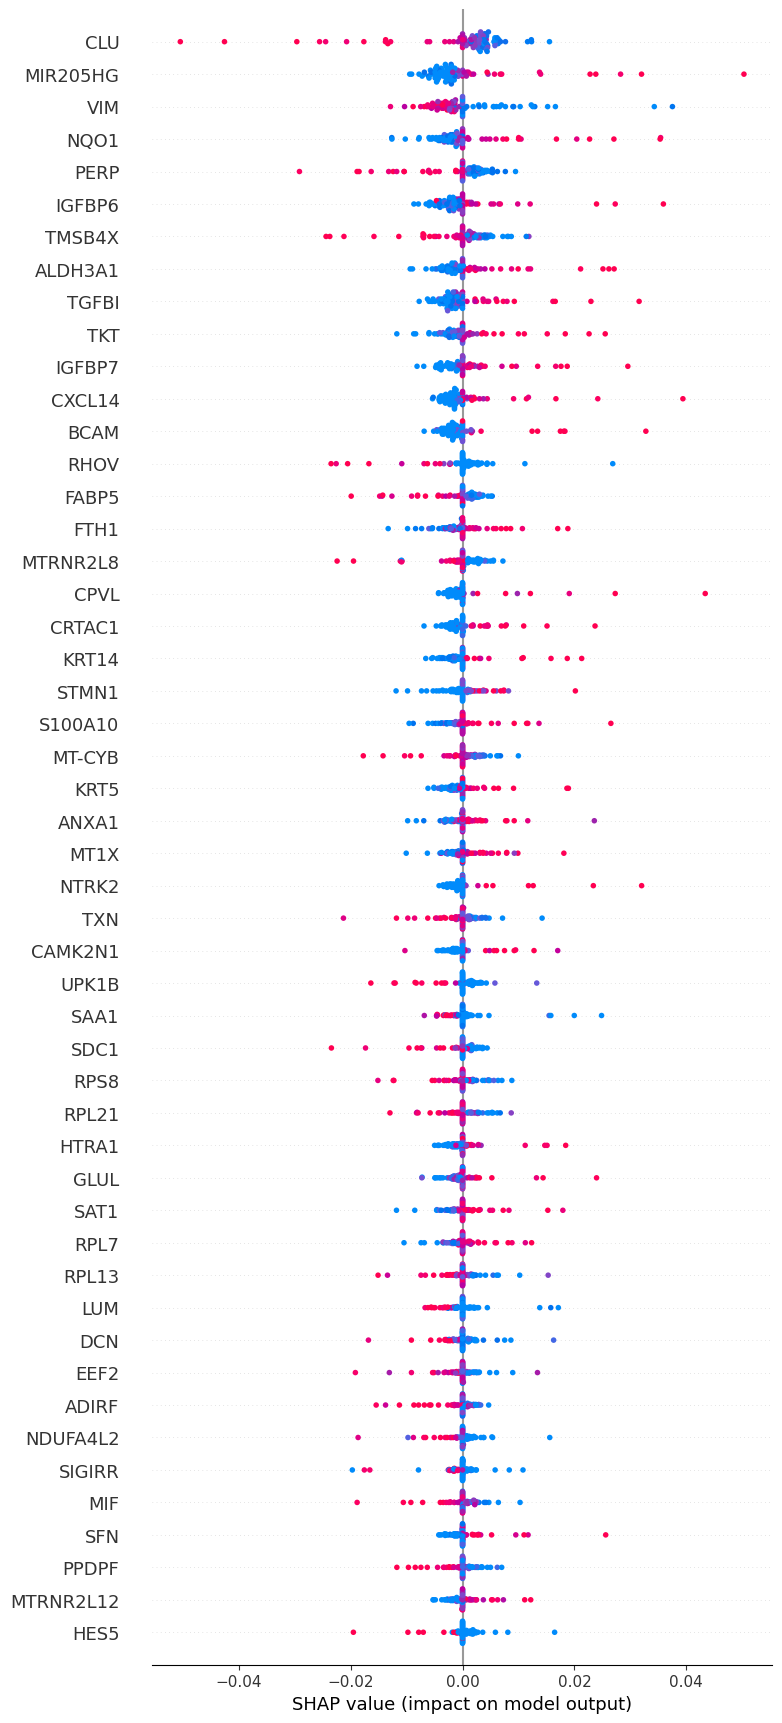

In [28]:
shap.summary_plot(shap_values[6], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


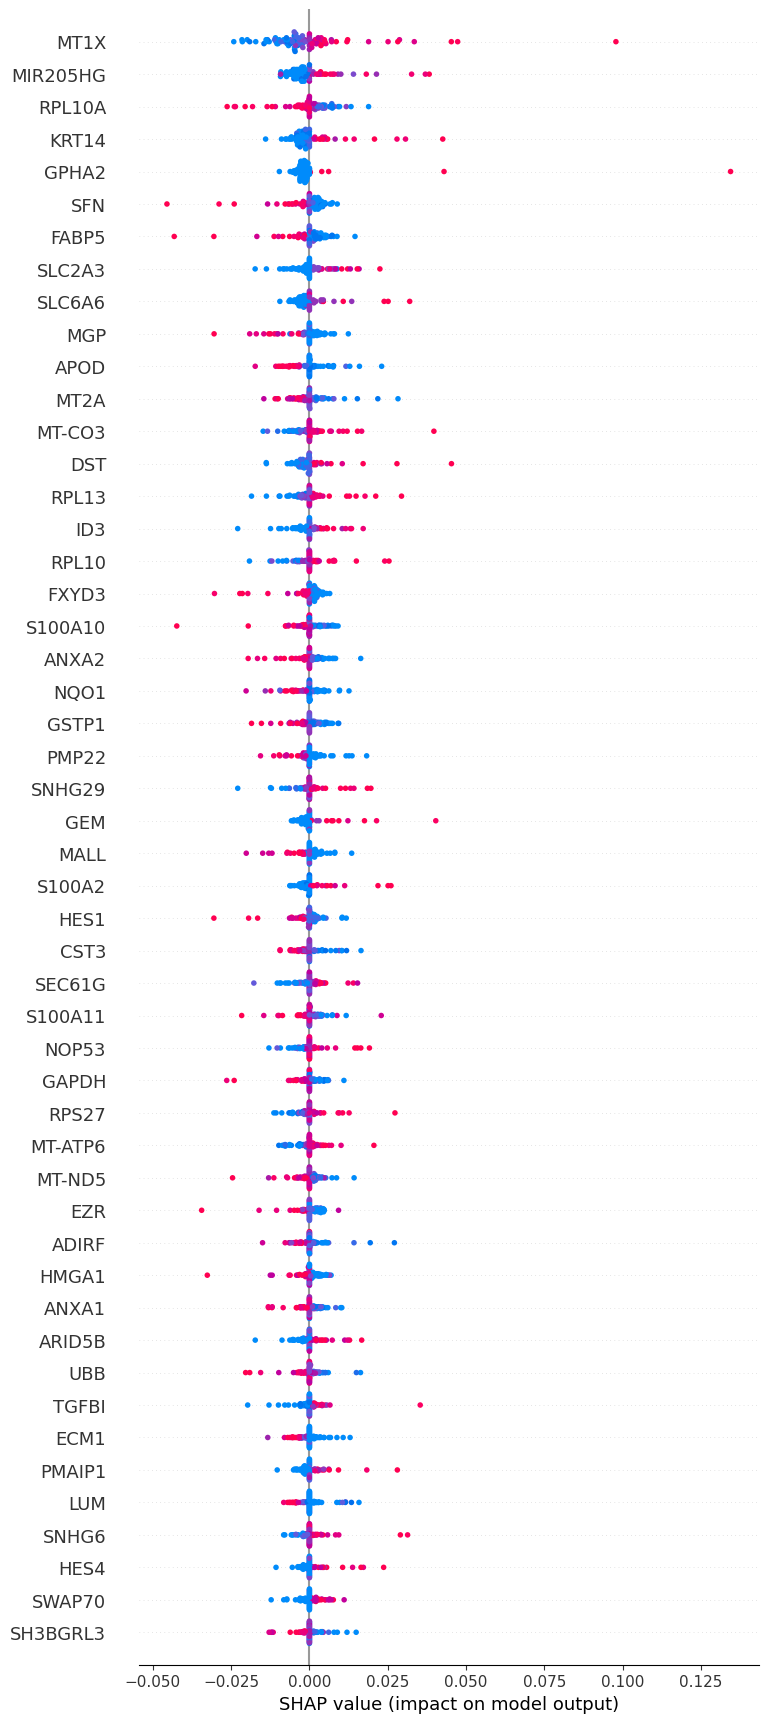

In [29]:
shap.summary_plot(shap_values[7], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


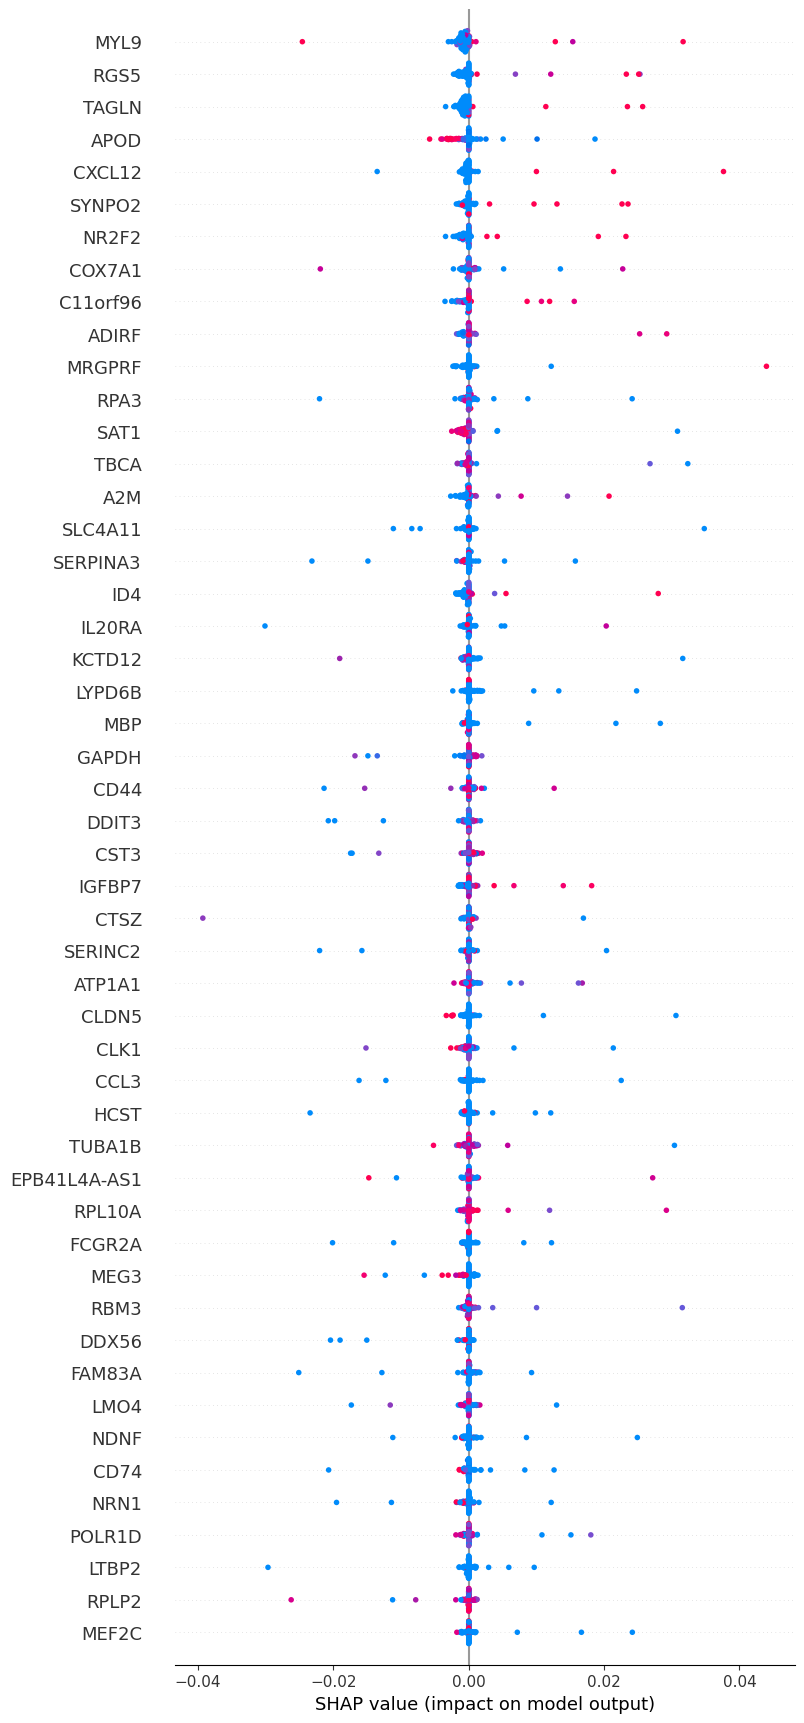

In [30]:
shap.summary_plot(shap_values[8], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


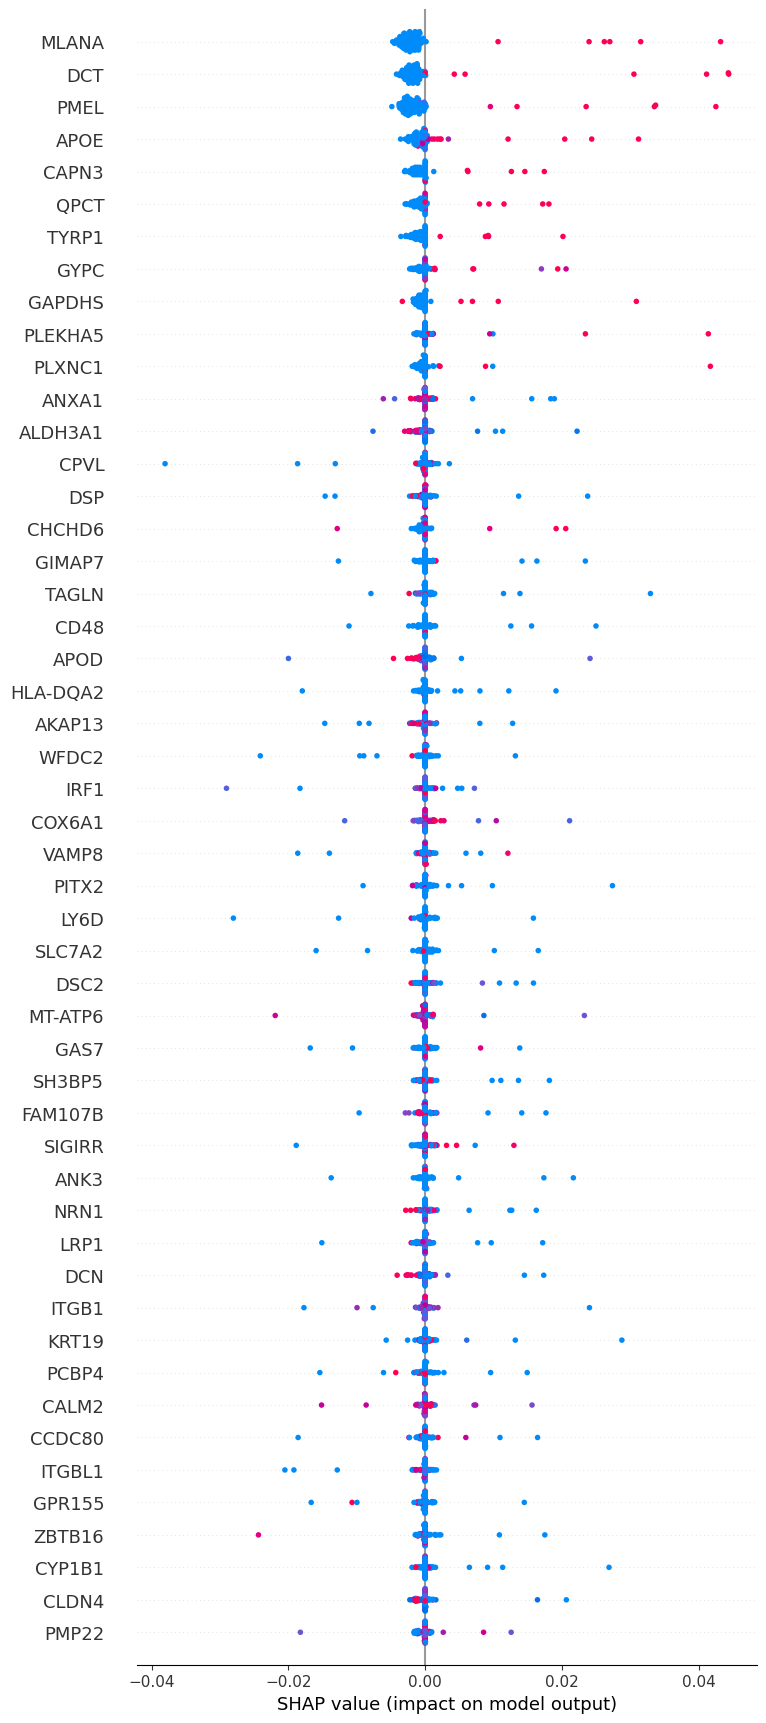

In [31]:
shap.summary_plot(shap_values[9], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


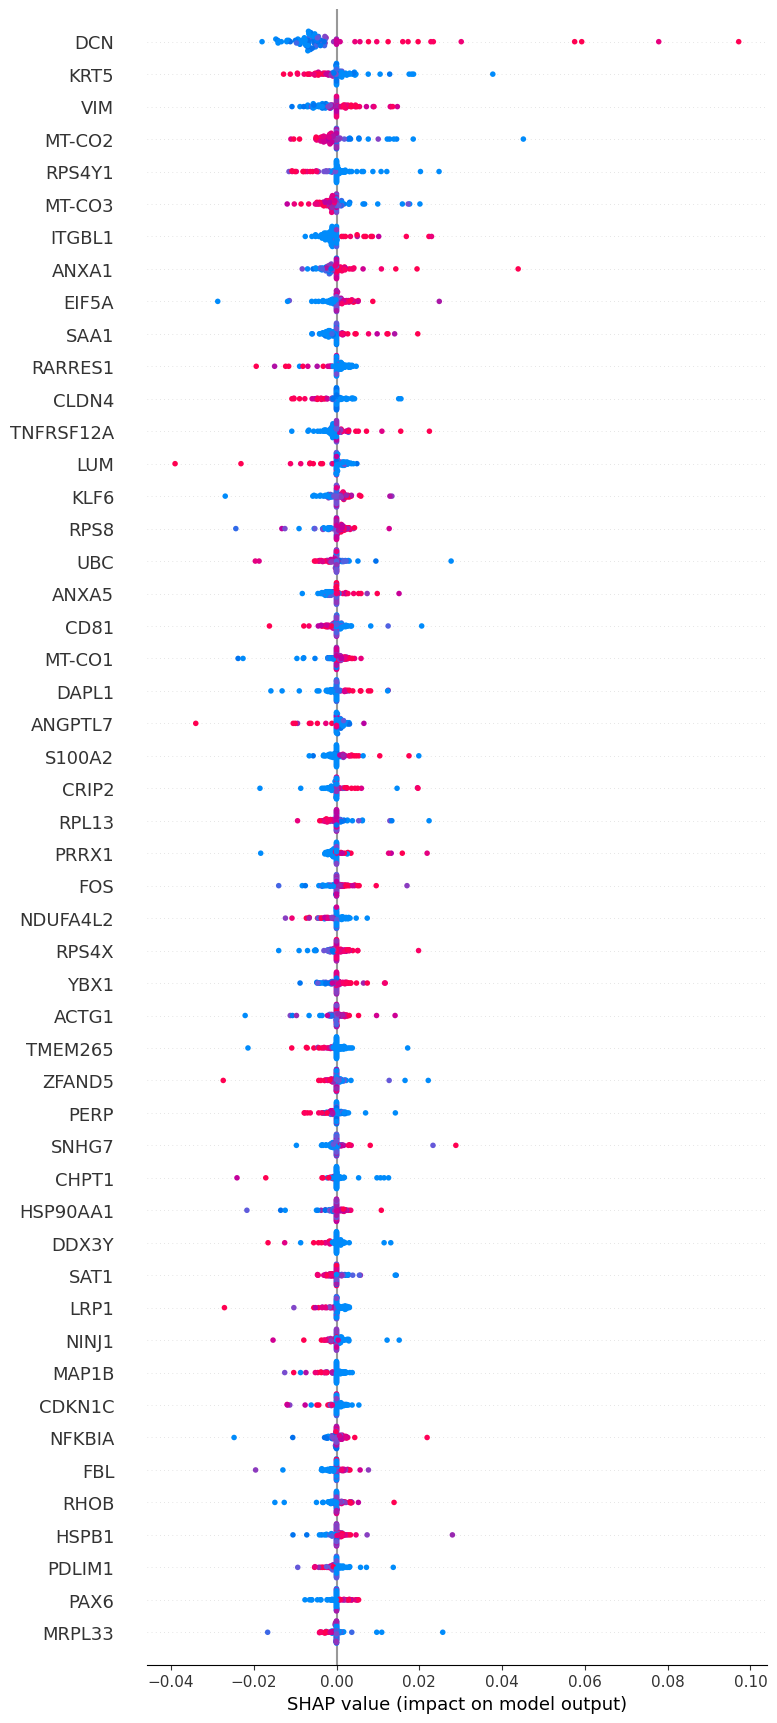

In [32]:
shap.summary_plot(shap_values[10], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


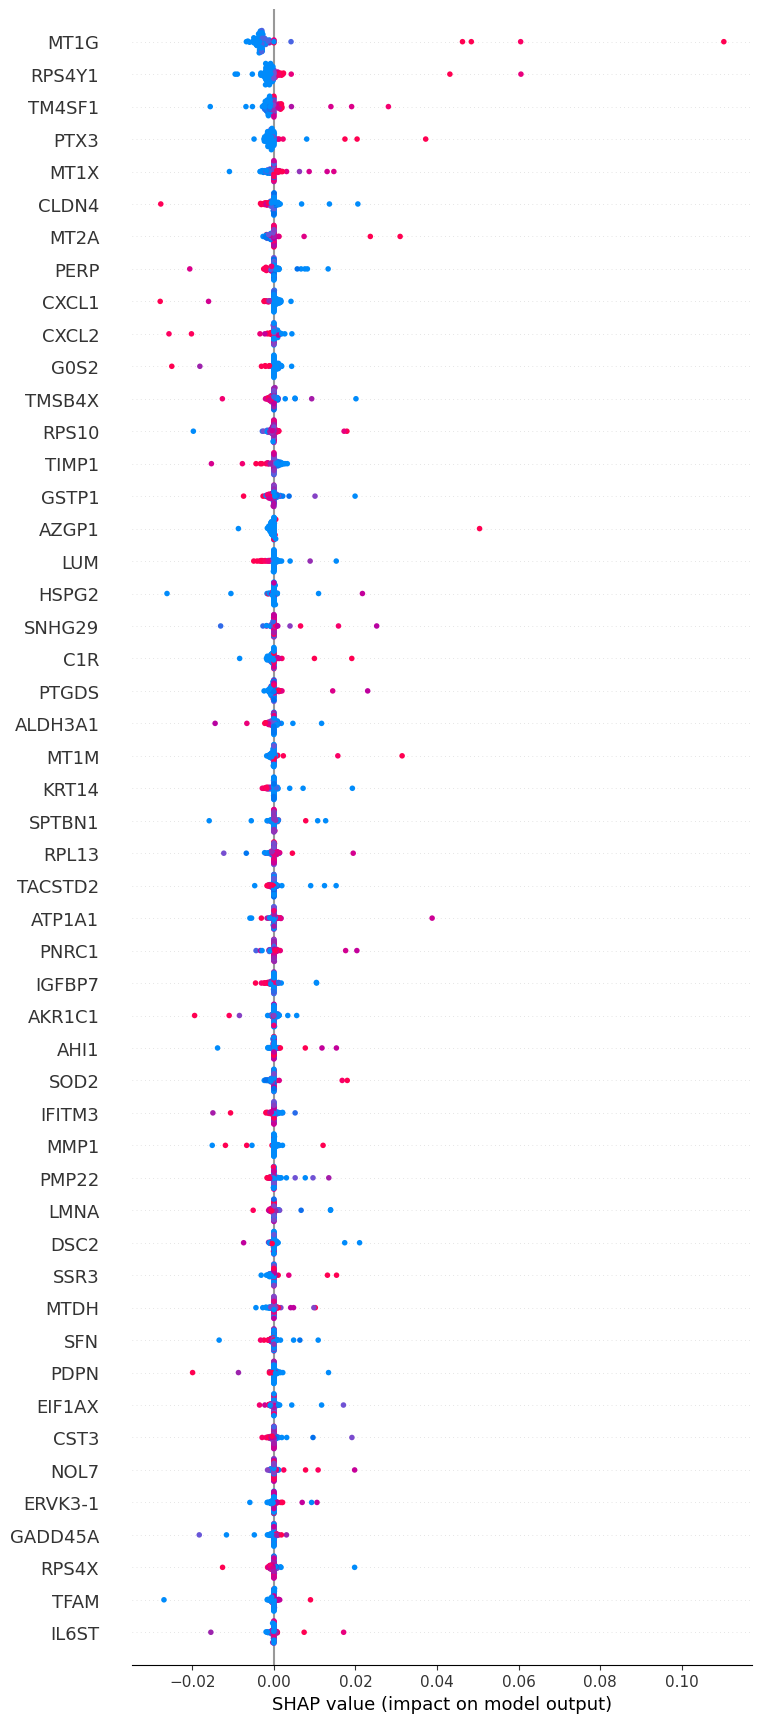

In [33]:
shap.summary_plot(shap_values[11], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


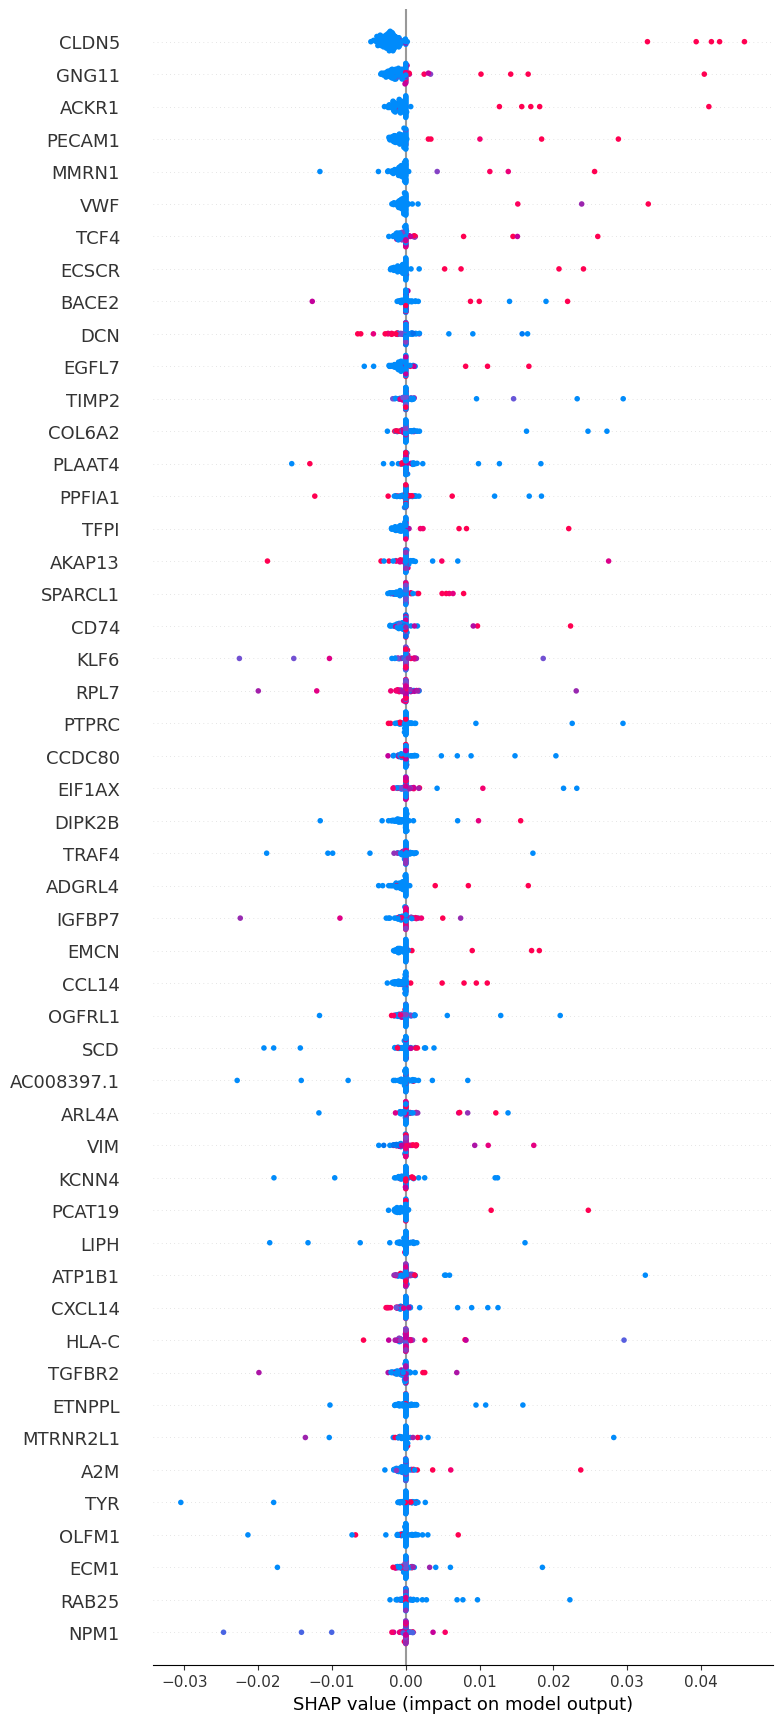

In [34]:
shap.summary_plot(shap_values[12], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


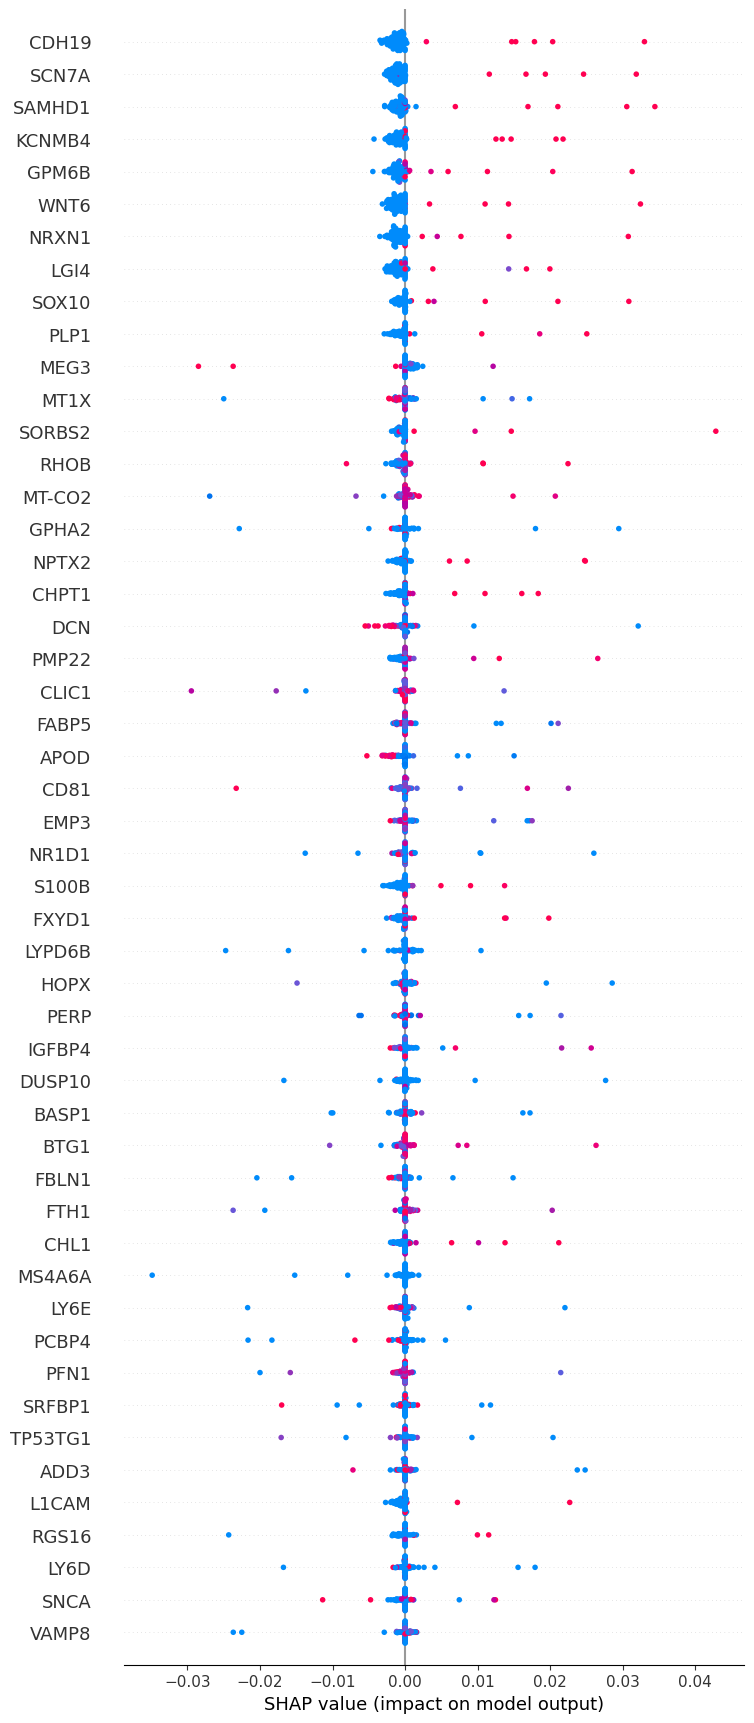

In [35]:
shap.summary_plot(shap_values[13], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


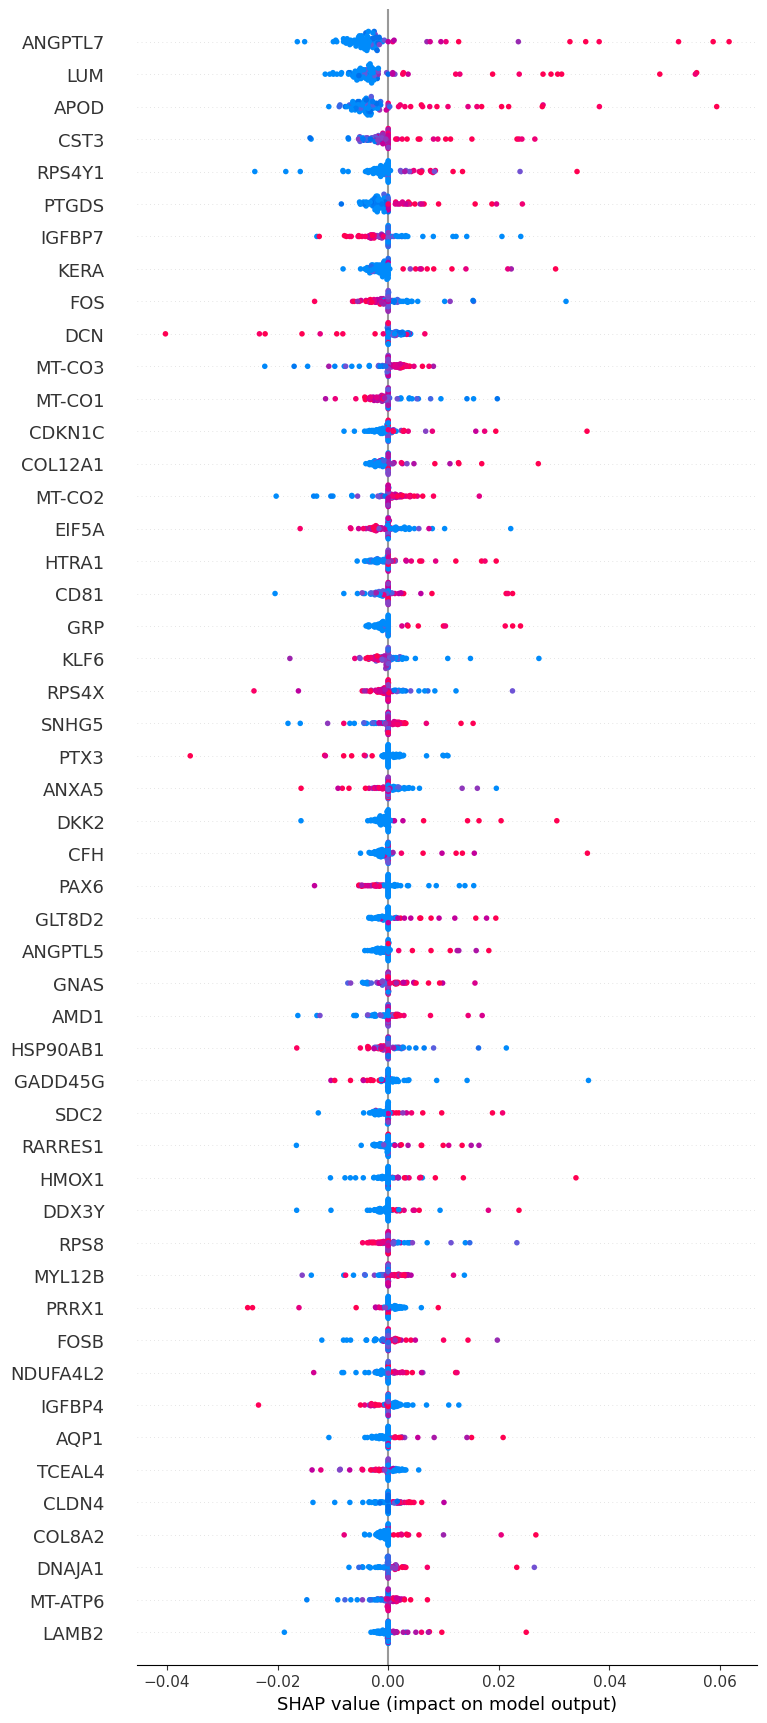

In [36]:
shap.summary_plot(shap_values[14], data_test.iloc[cell_nums], feature_names = data_test.columns,color_bar=False,max_display=50, class_inds="original", class_names=cls.classes_)

# LSC-1: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 43085, 54, 102, 226, 21149, 40716

In [ ]:
cell="LSC" # renamed LSC to LSC-1
cell_nums = [43085, 54, 102, 226, 21149, 40716]
trial = data_test.iloc[cell_nums]
trial["GPHA2"]

43085    0.000000
54       0.000000
102      0.000000
226      0.695312
21149    0.000000
40716    0.652344
Name: GPHA2, dtype: float16

In [ ]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [ ]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# For three cells -> takes about 12 minutes in total -> perhaps then logical if cells are similar?
# For 10 cells -> takes about 27 minutes per fold; but very high memory already -> 53 GB not more than this
# For 6 cells -> 1:34:06 total

100%|██████████| 6/6 [1:34:06<00:00, 941.06s/it]


In [ ]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [ ]:
cell="LSC"
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# LSC-2: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 245,2092,15680,21830,40692,64101

In [21]:
cell="LESC"
cell_nums = [245,2092,15680,21830,40692,64101]
trial = data_test.iloc[cell_nums]
trial["CPVL"]

245      0.700684
2092     0.271729
15680    0.171509
21830    0.343018
40692    0.397949
64101    0.443115
Name: CPVL, dtype: float16

In [22]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [23]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [3:19:08<00:00, 1991.44s/it]  


In [24]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,

In [25]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# LE: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 3042, 7585, 20935, 38122, 44845, 53940

In [18]:
cell="LE"
cell_nums = [3042, 7585, 20935, 38122, 44845, 53940]
trial = data_test.iloc[cell_nums]
trial["CXCL14"]

3042     0.714844
7585     0.455566
20935    0.802246
38122    0.388672
44845    0.485352
53940    0.496094
Name: CXCL14, dtype: float16

In [19]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [21]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# For three cells -> takes about 12 minutes in total -> perhaps then logical if cells are similar?
# For 10 cells -> takes about 27 minutes per fold; but very high memory already -> 53 GB not more than this
# For 6 cells -> 1:34:06 total

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [2:54:24<00:00, 1744.10s/it]  


In [22]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [23]:
cell="LE"
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# Cj: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 1,14705,33609,427270,56478,64996

In [20]:
cell="Cj"
cell_nums = [2,14705,33609,42727,56478,64996]
trial = data_test.iloc[cell_nums]
trial["KRT13"]

2        0.571289
14705    0.597656
33609    0.000000
42727    0.000000
56478    0.578125
64996    0.385498
Name: KRT13, dtype: float16

In [21]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [22]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [2:21:58<00:00, 1419.71s/it]  


In [23]:
shap_values

[array([[ 0.        , -0.00029757,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.00053078, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00103831, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00073185,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , 

In [24]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# CE: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 266, 7968, 12649, 29718, 43413, 54792

In [15]:
cell="CE"
cell_nums = [266, 7968, 12649, 29718, 43413, 54792]
trial = data_test.iloc[cell_nums]
trial["KRT3"]

266      0.297607
7968     0.424316
12649    0.106079
29718    0.458252
43413    0.168091
54792    0.000000
Name: KRT3, dtype: float16

In [16]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [17]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# For three cells -> takes about 12 minutes in total -> perhaps then logical if cells are similar?
# For 10 cells -> takes about 27 minutes per fold; but very high memory already -> 53 GB not more than this
# For 6 cells -> 1:34:06 total

100%|██████████| 6/6 [2:32:30<00:00, 1525.01s/it]  


In [18]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.00148837,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.  

In [19]:
cell="CE"
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

In [20]:
feature_importance.head(150)

,col_name,feature_importance_vals
14530,KRT13,0.005178
14510,KRT24,0.004778
8280,AQP3,0.003423
11018,KRT3,0.003246
10974,AQP5,0.003231
...,...,...
9648,TNNT3,0.000593
16418,PRMT1,0.000592
8171,CBWD1,0.000590
1174,S100A6,0.000588


# qSK: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 1076,13484,21232,28540,48553,53244

In [26]:
cell="qSK"
cell_nums = [1076,13484,21232,28540,48553,53244]
trial = data_test.iloc[cell_nums]
trial["AQP1"]

1076     0.570312
13484    0.221191
21232    0.531250
28540    0.000000
48553    0.279053
53244    0.360596
Name: AQP1, dtype: float16

In [27]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [28]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [1:55:31<00:00, 1155.18s/it]


In [29]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [30]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# SK: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 68, 18505, 22454, 30609, 30945, 32099

In [22]:
cell="SK"
cell_nums = [68, 18505, 22454, 30609, 30945, 32099]
trial = data_test.iloc[cell_nums]
trial["KERA"]

68       0.000000
18505    0.445312
22454    0.326904
30609    0.544434
30945    0.534180
32099    0.539551
Name: KERA, dtype: float16

In [23]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [24]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# For three cells -> takes about 12 minutes in total -> perhaps then logical if cells are similar?
# For 10 cells -> takes about 27 minutes per fold; but very high memory already -> 53 GB not more than this
# For 6 cells -> 1:34:06 total

100%|██████████| 6/6 [1:08:46<00:00, 687.83s/it]


In [25]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [26]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# TSK: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 8558, 32245, 32550, 33634, 33834, 58985

In [ ]:
cell="TSK"
cell_nums = [8558, 32245, 32550, 33634, 33834, 58985]
trial = data_test.iloc[cell_nums]
trial["MMP2"]

8558     0.000000
32245    0.326172
32550    0.222656
33634    0.363037
33834    0.000000
58985    0.140503
Name: MMP2, dtype: float16

In [ ]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [ ]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [1:17:43<00:00, 777.33s/it]


In [ ]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [ ]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# CF: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 31, 15040, 34168, 36238, 58954, 61494

In [14]:
cell="CF"
cell_nums = [31, 15040, 34168, 36238, 58954, 61494]
trial = data_test.iloc[cell_nums]
trial["FBLN1"]

31       0.000000
15040    0.326904
34168    0.126465
36238    0.000000
58954    0.631836
61494    0.601074
Name: FBLN1, dtype: float16

In [15]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [16]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [2:20:49<00:00, 1408.20s/it]  


In [17]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [18]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# EC: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 3358, 21187, 27105, 29028, 33802, 55190

In [112]:
cell="EC"
cell_nums = [27102, 27310, 28645, 29011, 29033, 33802]  #21187,27099,27102,27106, 27099(good)-27332

trial = data_test.iloc[cell_nums]
trial["COL8A2"]

#repick 29011 and 33802; col8a2 > 0.310547

27102    0.436035
27310    0.401367
28645    0.246094
29011    0.310547
29033    0.310547
33802    0.246094
Name: COL8A2, dtype: float16

In [100]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [101]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [1:55:21<00:00, 1153.54s/it]


In [102]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.00024564, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00028288, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.0002909 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -4.30607564e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        

In [107]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(250)

top150_shap = feature_importance.head(250)
top150_shap

top150_shap.to_csv(f'{cell}_shap_250.csv', sep='\t', index=False, header=True)

# Ves: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 149, 7255, 14334, 20927, 40040, 54911

In [18]:
cell="Ves"
cell_nums = [149, 7255, 14334, 20927, 40040, 54911]
trial = data_test.iloc[cell_nums]
trial["ACKR1"]

149      0.142700
7255     0.527832
14334    0.662598
20927    0.605957
40040    0.653809
54911    0.783203
Name: ACKR1, dtype: float16

In [19]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [20]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [1:37:48<00:00, 978.15s/it]


In [21]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [22]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# Mel: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 519, 12330, 40911, 48406, 53573, 62691

In [26]:
cell="Mel"
cell_nums = [519, 12330, 40911, 48406, 53573, 62691]
trial = data_test.iloc[cell_nums]
trial["MLANA"]

519      0.491211
12330    0.655273
40911    0.623047
48406    0.818359
53573    0.566406
62691    0.760254
Name: MLANA, dtype: float16

In [27]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [28]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [1:08:40<00:00, 686.67s/it]


In [29]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -6.78518033e-06,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array

In [30]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# IC: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 239, 6982, 13451, 24791, 26765, 64913

In [20]:
cell="IC"
cell_nums = [239, 6982, 13451, 24791, 26765, 64913]
trial = data_test.iloc[cell_nums]
trial["CCL3"]

239      0.764648
6982     0.251953
13451    0.703125
24791    0.812988
26765    0.748047
64913    0.413330
Name: CCL3, dtype: float16

In [21]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [22]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [1:02:41<00:00, 626.91s/it]


In [23]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [24]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# nm-cSC: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 375, 1554, 5004, 20956, 61871, 64328

In [30]:
cell="nm-cSC"
cell_nums = [375, 1554, 5004, 20956, 61871, 64328]
trial = data_test.iloc[cell_nums]
trial["SCN7A"]

375      0.500000
1554     0.736328
5004     0.449219
20956    0.715820
61871    0.542969
64328    0.193481
Name: SCN7A, dtype: float16

In [31]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [32]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [1:27:48<00:00, 878.15s/it]


In [33]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [34]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)

# MC: Values of 6 specific cells background on 6 specific selected cells
#### Cell numbers 2049, 7429, 12622, 20962, 42970, 62700

In [41]:
cell="MC"
cell_nums = [2049, 7429, 12622, 20962, 42970, 62700]
trial = data_test.iloc[cell_nums]
trial["MYL9"]

2049     0.498291
7429     0.249146
12622    0.322021
20962    0.446289
42970    0.124573
62700    0.197388
Name: MYL9, dtype: float16

In [42]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test.iloc[cell_nums])
explainer

In [43]:
shap_values = explainer.shap_values(data_test.iloc[cell_nums])
# Note 10 cells takes very long -> 45 min/cell
# 6 cells 33 minutes, better

100%|██████████| 6/6 [46:11<00:00, 461.92s/it]


In [44]:
shap_values

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [45]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(150)

top150_shap = feature_importance.head(150)
top150_shap

top150_shap.to_csv(f'{cell}_shap_150.csv', sep='\t', index=False, header=True)